### Shot xG Analysis – WWC Final Spain vs England

This project performs a visual analysis of shot quality (xG) for three key Spanish players in the 2023 FIFA Women’s World Cup Final against England:

1. Aitana Bonmatí
2. Clàudia Pina
3. Olga Carmona

#### Data

The dataset comes from StatsBomb open event data and includes only shots. The dataframe was filtered to keep the relevant fields for xG analysis, such as:

1. Player name and ID
2. Shot location (x, y)
3. Shot end location (x, y, z)
4. Shot outcome
5. Shot body part
6. Under pressure indicator
7. Expected Goals value (shot_statsbomb_xg)
8. Missing values were checked and cleaned when necessary.

#### Visual Analysis

1. A pitch-based shot map was created to compare players:
2. Each shot is plotted at its on-pitch location
3. Marker size is proportional to the xG value
4. Different colors represent each player for easy comparison

This visualization helps identify where each player took shots from and which attempts had higher scoring probability.

#### Objective

The goal of this notebook is to provide an introductory player-level attacking analysis using open football event data. It highlights shooting tendencies and scoring threat in one of the most important matches in women’s football history.

In [1]:
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.5 MB/s eta 0:00:00


In [2]:
# https://github.com/statsbomb/open-data
# https://github.com/wswager/womens_soccer_expected_goals_model/blob/main/data_preprocessing/expected_goals_data_preprocessing_notebook.ipynb
# https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/tree/master
# https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html
# https://www.youtube.com/watch?v=310_eW0hUqQ&ab_channel=FriendsofTracking
# https://twitter.com/LanusStats/status/1456381238252605443
# https://theanalyst.com/eu/2021/06/que-son-los-goles-esperados-xg/

import seaborn as sns
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

## Let's first search for the game we want 

In [3]:
competitions = sb.competitions()

In [4]:
UEFA_womens_euro = competitions[(competitions['competition_gender'] == 'female') 
                               & (competitions['season_name'] == '2025')]
UEFA_womens_euro

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
71,53,315,Europe,UEFA Women's Euro,female,False,True,2025,2025-07-28T14:19:20.467348,2025-07-29T16:03:07.355174,2025-07-29T16:03:07.355174,2025-07-28T14:19:20.467348


### Once we have the game we will look for the match and the events

In [5]:
matches = sb.matches(competition_id=53, season_id=315)
# matches.columns
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,4020846,2025-07-27,16:00:00.000,Europe - UEFA Women's Euro,2025,England Women's,Spain Women's,1,1,available,...,2025-07-29T16:03:07.355174,6,Final,St. Jakob-Park,Stéphanie Frappart,Sarina Glotzbach-Wiegman,Montserrat Tomé Vázquez,1.1.0,2,2
1,4020077,2025-07-23,19:00:00.000,Europe - UEFA Women's Euro,2025,Germany Women's,Spain Women's,0,1,available,...,2025-07-25T15:22:27.432293,5,Semi-finals,Stadion Letzigrund,Edina Alves Batista,Christian Richard Wück,Montserrat Tomé Vázquez,1.1.0,2,2
2,4020005,2025-07-22,19:00:00.000,Europe - UEFA Women's Euro,2025,England Women's,Italy Women's,2,1,available,...,2025-07-24T13:46:36.152311,5,Semi-finals,Stade de Genève,Ivana Martinčić,Sarina Glotzbach-Wiegman,Andrea Soncin,1.1.0,2,2
3,4018357,2025-07-19,19:00:00.000,Europe - UEFA Women's Euro,2025,France Women's,Germany Women's,1,1,available,...,2025-07-20T21:36:08.622324,4,Quarter-finals,St. Jakob-Park,Tess Olofsson,Laurent Pierre Bonadéi,Christian Richard Wück,1.1.0,2,2
4,4018356,2025-07-18,19:00:00.000,Europe - UEFA Women's Euro,2025,Spain Women's,Switzerland Women's,2,0,available,...,2025-07-19T21:26:11.543565,4,Quarter-finals,Stadion Wankdorf,Maria Sole Ferrieri Caputi,Montserrat Tomé Vázquez,Pia Mariane Sundhage,1.1.0,2,2


### We keep only spain matches

In [6]:
spain_matches = matches[(matches['home_team'] == "Spain Women's") | (matches['away_team'] == "Spain Women's") ]

spain_matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,4020846,2025-07-27,16:00:00.000,Europe - UEFA Women's Euro,2025,England Women's,Spain Women's,1,1,available,...,2025-07-29T16:03:07.355174,6,Final,St. Jakob-Park,Stéphanie Frappart,Sarina Glotzbach-Wiegman,Montserrat Tomé Vázquez,1.1.0,2,2
1,4020077,2025-07-23,19:00:00.000,Europe - UEFA Women's Euro,2025,Germany Women's,Spain Women's,0,1,available,...,2025-07-25T15:22:27.432293,5,Semi-finals,Stadion Letzigrund,Edina Alves Batista,Christian Richard Wück,Montserrat Tomé Vázquez,1.1.0,2,2
4,4018356,2025-07-18,19:00:00.000,Europe - UEFA Women's Euro,2025,Spain Women's,Switzerland Women's,2,0,available,...,2025-07-19T21:26:11.543565,4,Quarter-finals,Stadion Wankdorf,Maria Sole Ferrieri Caputi,Montserrat Tomé Vázquez,Pia Mariane Sundhage,1.1.0,2,2
11,3998855,2025-07-11,19:00:00.000,Europe - UEFA Women's Euro,2025,Italy Women's,Spain Women's,1,3,available,...,2025-07-14T10:19:31.981150,3,Group Stage,Stadion Wankdorf,Iuliana Elena Demetrescu,Andrea Soncin,Montserrat Tomé Vázquez,None,None,None
20,3998847,2025-07-07,16:00:00.000,Europe - UEFA Women's Euro,2025,Spain Women's,Belgium Women's,6,2,available,...,2025-07-13T09:55:29.474598,2,Group Stage,Stockhorn Arena,Katalin Kulcsar,Montserrat Tomé Vázquez,Elisabet Gunnarsdottir,1.1.0,2,2


### We get the events of that specific game

In [7]:
game = sb.events(match_id=4020846)
game.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",England Women's,865,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...",Spain Women's,863,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,England Women's,865,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,England Women's,865,00:00:00.000,Half Start,NaN


### Which are the players of the game ?

In [8]:
spain = game[game['team'] == "Spain Women's"]
spain['player'].value_counts()
# spain

player
Ona Batlle Pascual                  336
Laia Aleixandri López               311
María Francesca Caldentey Oliver    306
Aitana Bonmati Conca                294
Patricia Guijarro Gutiérrez         274
Olga  Carmona García                268
Irene Paredes Hernandez             259
Alexia Putellas Segura              167
Athenea del Castillo Belvide        149
Claudia Pina Medina                 114
Catalina Thomas Coll Lluch          100
Victoria López                       96
Esther Gonzalez Rodríguez            89
Salma Paralluelo Ayingono            61
Leila Ouahabi El Ouahabi             25
Name: count, dtype: int64

In [9]:
game_events = spain[(spain['player'] == 'Aitana Bonmati Conca') | (spain['player'] == 'Claudia Pina Medina') | (spain['player'] == 'Olga  Carmona García')]
game_events

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:00:30.040,Pass,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:00:31.934,Pass,True
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:02:02.251,Pass,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:02:05.801,Pass,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:02:12.329,Pass,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:15:34.320,Foul Won,True
4780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:03:37.983,Foul Won,True
4781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:05:28.655,Foul Won,True
4796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:26:28.668,Injury Stoppage,NaN


### Create the xG data per players

In [10]:
# Select only the columns we need 

columns_needed = [
    'player',             # Player name
    'player_id',          # Player ID
    'team',               # Team name
    'team_id',            # Team ID
    'type',               # Event type (Shot, Pass, etc.)
    'location',           # Event starting coordinates
    'shot_end_location',  # Final shot coordinates (optional)
    'shot_statsbomb_xg',  # Expected goals (xG)
    'shot_outcome',       # Shot outcome
    'shot_body_part',     # Body part used (foot, head, etc.)
    'shot_first_time',    # Whether it was a first-time shot
    'shot_type',          # Type of shot
    'under_pressure'      # Whether the player was under pressure
]

In [11]:
# We create the data frame with the columns we need
game_events_filtered_df = game_events[columns_needed]

# game_events_filtered_df  = game_events_filtered_df.dropna(subset=['location', 'shot_statsbomb_xg'])
game_events_filtered_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,player,player_id,team,team_id,type,location,shot_end_location,shot_statsbomb_xg,shot_outcome,shot_body_part,shot_first_time,shot_type,under_pressure
16,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[11.1, 0.1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[9.2, 1.8]",NaN,NaN,NaN,NaN,NaN,NaN,True
35,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[44.9, 57.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[46.7, 61.7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[55.4, 55.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[41.8, 5.5]",NaN,NaN,NaN,NaN,NaN,NaN,True
4780,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[26.2, 31.2]",NaN,NaN,NaN,NaN,NaN,NaN,True
4781,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[59.6, 11.2]",NaN,NaN,NaN,NaN,NaN,NaN,True
4796,Olga Carmona García,49836.0,Spain Women's,863,Injury Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### some other usefull commands...

In [12]:
# We can keep only one player. In my case I chose 3 but another way to select only ONE would be...

# aitana_df = game_events_filtered_df[game_events_filtered_df['player'] == 'Aitana Bonmati Conca']
# aitana_df.head() -> This would be a dataframe
# aitana_df['type'].unique() -> Which types do we have?
# aitana_df['type'].value_counts()

### What does the column `type` show? 

In StatsBomb data, the type column describes the kind of event:

1. Pass
2. Carry
3. Shot
4. Pressure
5. Duel
6. Clearance
7. Foul Committed
8. Foul Won
9. Substitution
10. Goalkeeper Action
11. 50/50

### We can keep only the shots...

In [13]:
# We keep only the shots

# df_aitana_shots = aitana_df[aitana_df['type'] == 'Shot']
# df_aitana_shots = df_aitana_shots.dropna(subset=['location', 'shot_statsbomb_xg'])
# df_aitana_shots

# Clean the DF when there are rows with NaN values and in xG coordinates
# aitana_df = aitana_df.dropna(subset=['location', 'shot_statsbomb_xg'])
# aitana_df

# aitana_df[['x','y']] = aitana_df['location'].apply(pd.Series)

# df_aitana_shots

# esta es otra forma de hacer lo mismo que hicimos arriba
# --- Separar las coordenadas iniciales en columnas x e y ---
# df_aitana_shots['x'] = df_aitana_shots['location'].apply(lambda loc: loc[0]) # dame los valores de la primer columna (x)
# df_aitana_shots['y'] = df_aitana_shots['location'].apply(lambda loc: loc[1]) # dame los valores de la segunda columna (y)

In [14]:
# Create 2 new columns with the X and Y values

events_df = game_events_filtered_df.copy()

events_df[['x','y']] = events_df['location'].apply(pd.Series)
events_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,player,player_id,team,team_id,type,location,shot_end_location,shot_statsbomb_xg,shot_outcome,shot_body_part,shot_first_time,shot_type,under_pressure,x,y
16,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[11.1, 0.1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1,0.1
18,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[9.2, 1.8]",NaN,NaN,NaN,NaN,NaN,NaN,True,9.2,1.8
35,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[44.9, 57.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.9,57.3
37,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[46.7, 61.7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.7,61.7
39,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[55.4, 55.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.4,55.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[41.8, 5.5]",NaN,NaN,NaN,NaN,NaN,NaN,True,41.8,5.5
4780,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[26.2, 31.2]",NaN,NaN,NaN,NaN,NaN,NaN,True,26.2,31.2
4781,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[59.6, 11.2]",NaN,NaN,NaN,NaN,NaN,NaN,True,59.6,11.2
4796,Olga Carmona García,49836.0,Spain Women's,863,Injury Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# if we want, we can compare and save it in a df (if we want, but it is not neccesary)

# location_x_y = df_aitana_shots[['x','y','location']]
# location_x_y

### Separate final coords

Now we will create 3 new columns related with the `shot_end_location`

In [16]:
# df_aitana_shots['shot_end_location'].apply(pd.Series)
# df_aitana_shots[['shot_end_location_x','shot_end_location_y','shot_end_location_z']] = df_aitana_shots['shot_end_location'].apply(pd.Series)
# df_aitana_shots[['shot_end_location_x','shot_end_location_y','shot_end_location_z','shot_end_location']]

events_df[['shot_end_location_x','shot_end_location_y','shot_end_location_z']] = events_df['shot_end_location'].apply(pd.Series)
events_df[['shot_end_location_x','shot_end_location_y','shot_end_location_z','shot_end_location']]

# another way to do it 
'''
df_shots['end_x'] = df_shots['shot_end_location'].apply(lambda loc: loc[0] if loc else None)
df_shots['end_y'] = df_shots['shot_end_location'].apply(lambda loc: loc[1] if loc else None)
'''

"\ndf_shots['end_x'] = df_shots['shot_end_location'].apply(lambda loc: loc[0] if loc else None)\ndf_shots['end_y'] = df_shots['shot_end_location'].apply(lambda loc: loc[1] if loc else None)\n"

In [17]:
xG_df = events_df.copy()
xG_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,player,player_id,team,team_id,type,location,shot_end_location,shot_statsbomb_xg,shot_outcome,shot_body_part,shot_first_time,shot_type,under_pressure,x,y,shot_end_location_x,shot_end_location_y,shot_end_location_z
16,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[11.1, 0.1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1,0.1,NaN,NaN,NaN
18,Olga Carmona García,49836.0,Spain Women's,863,Pass,"[9.2, 1.8]",NaN,NaN,NaN,NaN,NaN,NaN,True,9.2,1.8,NaN,NaN,NaN
35,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[44.9, 57.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.9,57.3,NaN,NaN,NaN
37,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[46.7, 61.7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.7,61.7,NaN,NaN,NaN
39,Aitana Bonmati Conca,15284.0,Spain Women's,863,Pass,"[55.4, 55.3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.4,55.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[41.8, 5.5]",NaN,NaN,NaN,NaN,NaN,NaN,True,41.8,5.5,NaN,NaN,NaN
4780,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[26.2, 31.2]",NaN,NaN,NaN,NaN,NaN,NaN,True,26.2,31.2,NaN,NaN,NaN
4781,Claudia Pina Medina,32838.0,Spain Women's,863,Foul Won,"[59.6, 11.2]",NaN,NaN,NaN,NaN,NaN,NaN,True,59.6,11.2,NaN,NaN,NaN
4796,Olga Carmona García,49836.0,Spain Women's,863,Injury Stoppage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plots for Match Analysis

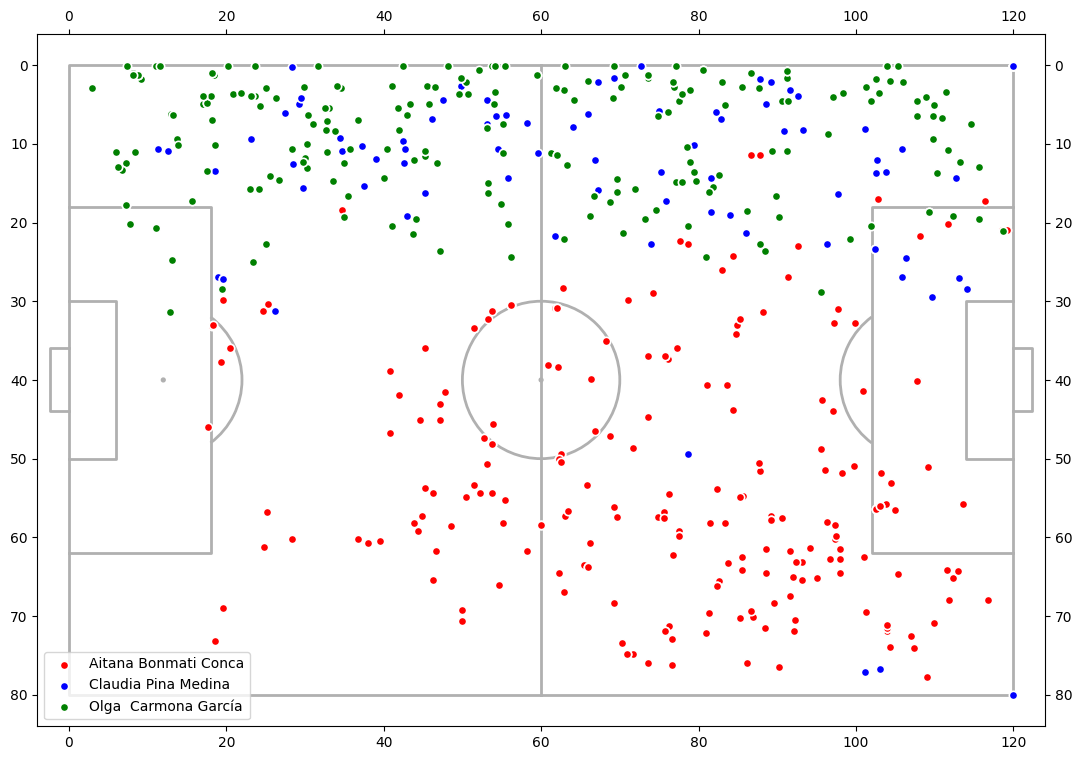

In [18]:
fig, ax = plt.subplots(figsize=(13,13))

pitch = Pitch(
    pitch_type='statsbomb',
    axis=True,
    label=True,
    tick=True,
    goal_type='box'
)

pitch.draw(ax=ax)

players = ['Aitana Bonmati Conca', 'Claudia Pina Medina', 'Olga  Carmona García']

player_colors = {
    'Aitana Bonmati Conca':'red',
    'Claudia Pina Medina':'blue',
    'Olga  Carmona García':'green'
}

for player, color in player_colors.items():
    player_data = xG_df[xG_df['player'] == player]
    pitch.scatter(player_data['x'], 
                  player_data['y'], 
                  c=color,
                  ax=ax,
                  edgecolor='white',
                  linewidth=1.2,
                  label=player
                 )

plt.legend()

### Shot Map (all shots on pitch)

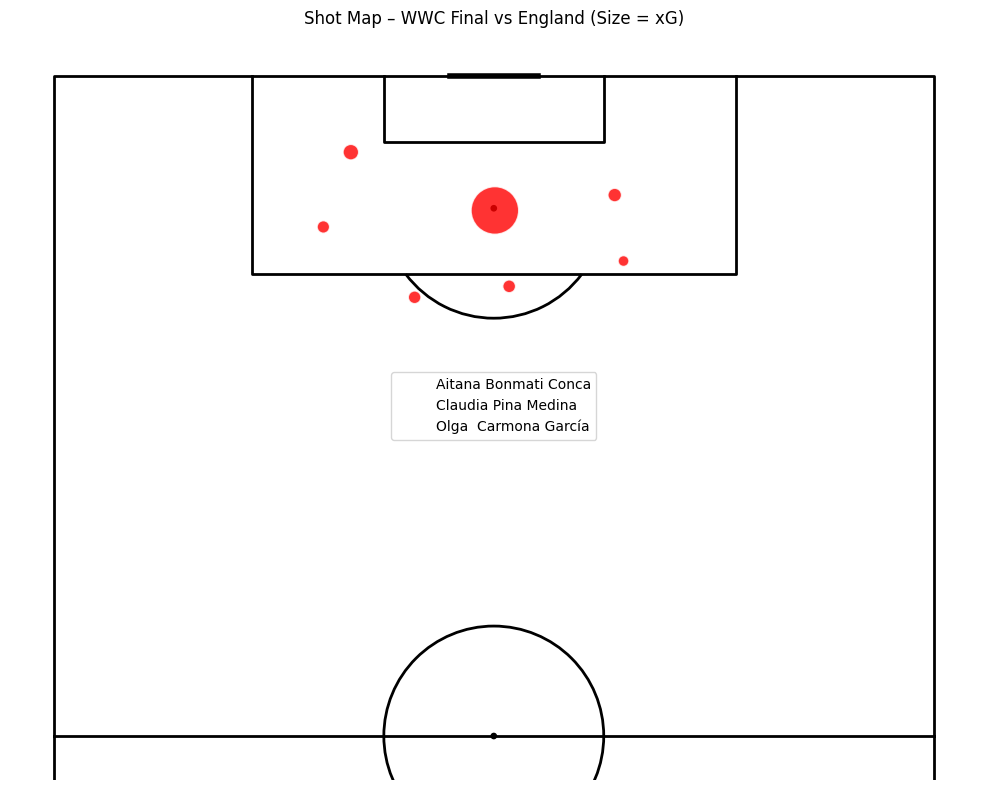

In [19]:

pitch = VerticalPitch(pitch_type='statsbomb', 
                      half=True, 
                      line_color='black')

fig, ax = pitch.draw(figsize=(11, 8))

for player, color in player_colors.items():
    player_data = xG_df[xG_df['player'] == player]
    pitch.scatter(
        player_data['x'], 
        player_data['y'],
        s=player_data['shot_statsbomb_xg'] * 1500,
        c=player_data['shot_outcome'].eq('Goal').map({True: 'gold', False: 'red'}),
        alpha=0.8, 
        edgecolor='white',
        label=player,
        ax=ax
    )

plt.title('Shot Map – WWC Final vs England (Size = xG)')
plt.legend()
plt.show()


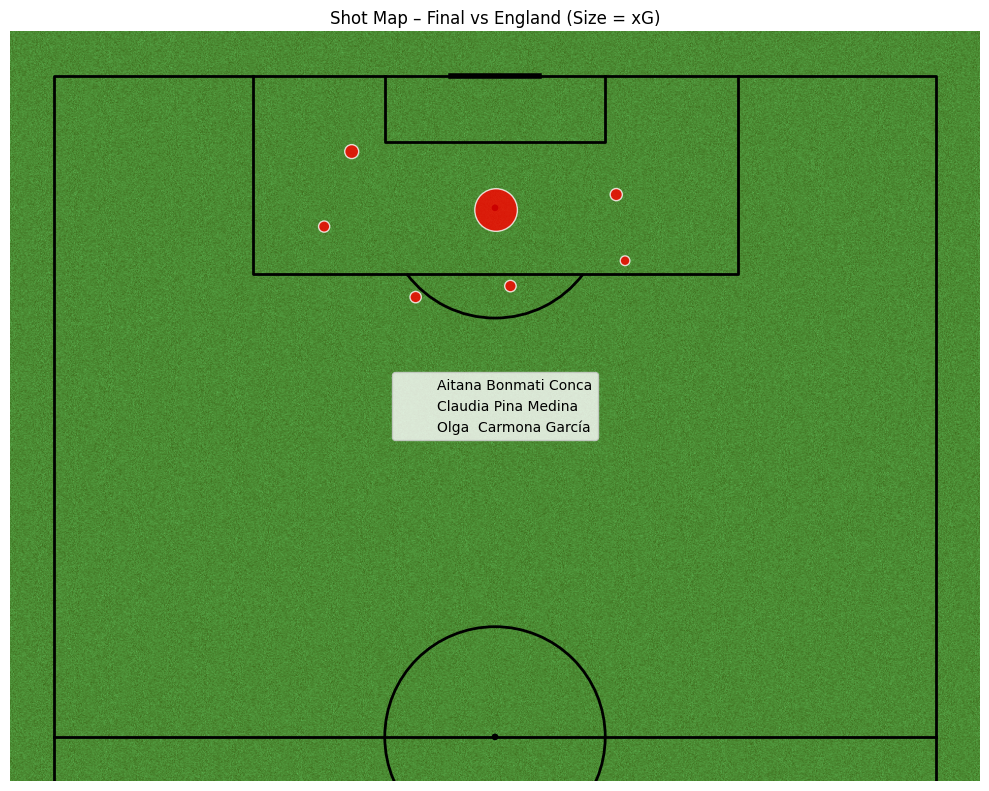

In [20]:
pitch = VerticalPitch(pitch_type='statsbomb', 
                      pitch_color='grass', 
                      half=True, 
                      line_color='black')

fig, ax = pitch.draw(figsize=(10, 8))

for player, color in player_colors.items():
    player_shots = xG_df[xG_df['player'] == player]
    pitch.scatter(
        player_shots.x,
        player_shots.y,
        s=player_shots.shot_statsbomb_xg * 1200,
        c=player_shots['shot_outcome'].eq('Goal').map({
            True: 'gold',
            False: 'red'}),
        alpha=0.8,
        edgecolor='white',
        label=player,
        ax=ax
    )

plt.legend()
plt.title('Shot Map – Final vs England (Size = xG)')
plt.show()


### Shot Outcomes Bar Chart

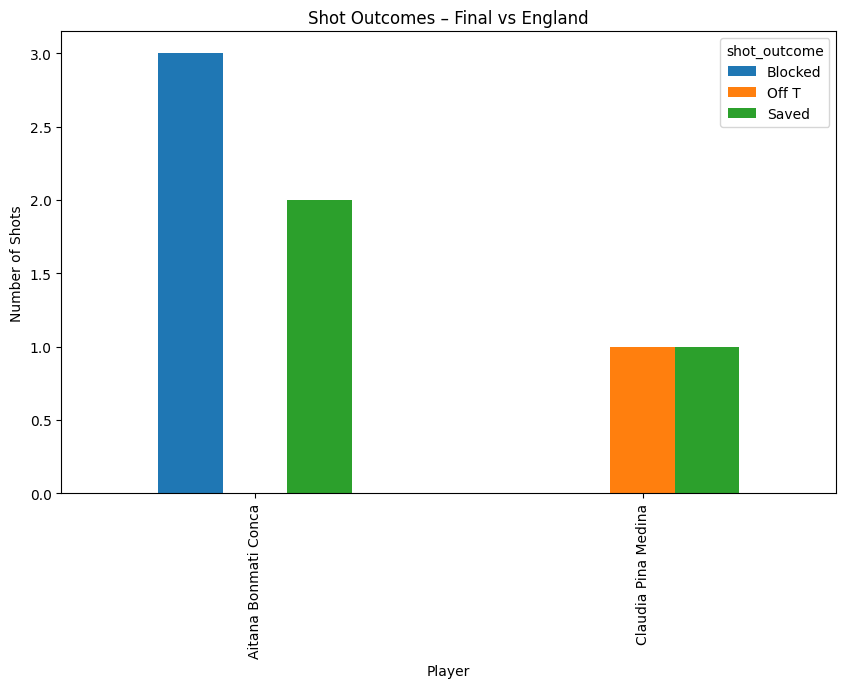

In [21]:
outcomes = xG_df.groupby(['player', 'shot_outcome']).size().unstack(fill_value=0)

outcomes.plot(kind='bar', figsize=(10,6))
plt.title('Shot Outcomes – Final vs England')
plt.xlabel('Player')
plt.ylabel('Number of Shots')
plt.show()


### xG by Shot Type

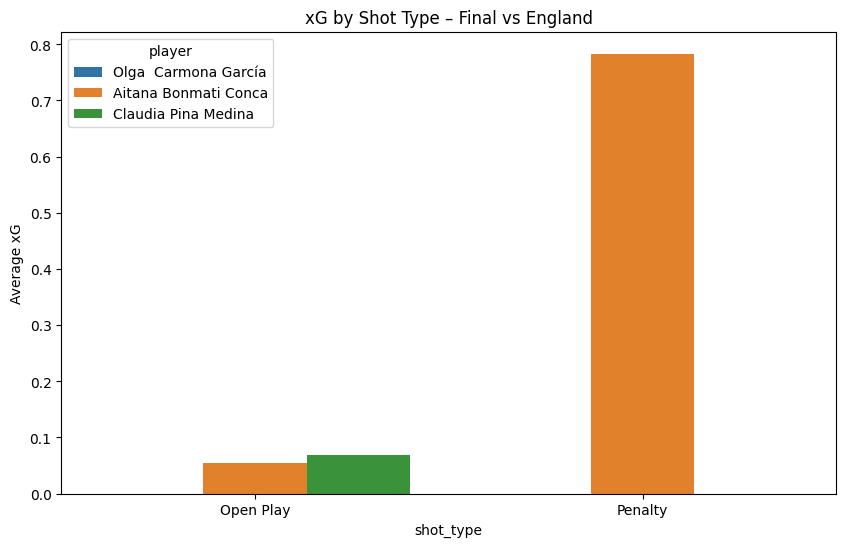

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=xG_df, 
            x='shot_type', 
            y='shot_statsbomb_xg', hue='player', 
            errorbar=None)
plt.title('xG by Shot Type – Final vs England')
plt.ylabel('Average xG')
plt.show()


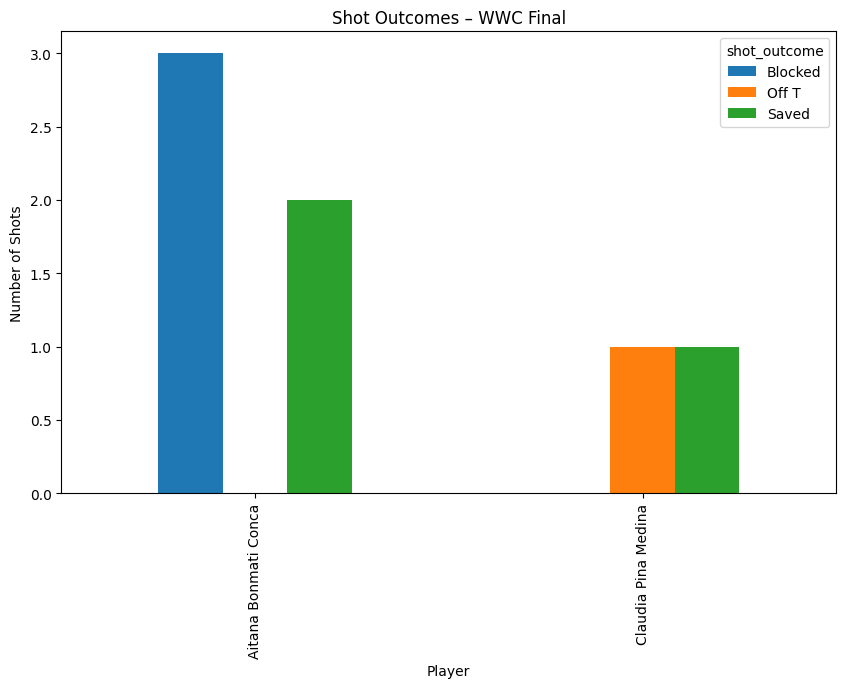

In [23]:
outcomes = xG_df.groupby(['player', 'shot_outcome']).size().unstack(fill_value=0)

outcomes.plot(kind='bar', figsize=(10,6))
plt.title('Shot Outcomes – WWC Final')
plt.xlabel('Player')
plt.ylabel('Number of Shots')
plt.show()

### xG by Body Part – WWC Final

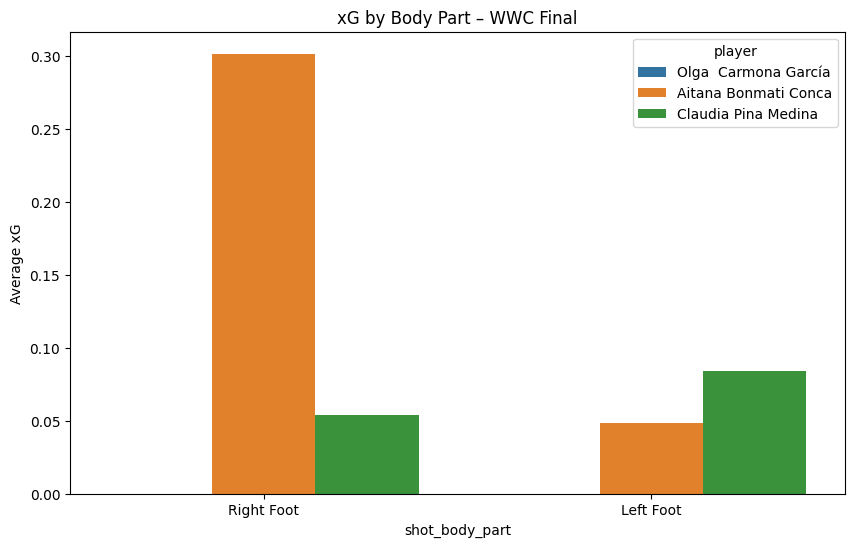

In [24]:
plt.figure(figsize=(10,6))

sns.barplot(data=xG_df, x='shot_body_part', 
            y='shot_statsbomb_xg', 
            hue='player', 
            errorbar=None)
plt.title('xG by Body Part – WWC Final')
plt.ylabel('Average xG')
plt.show()


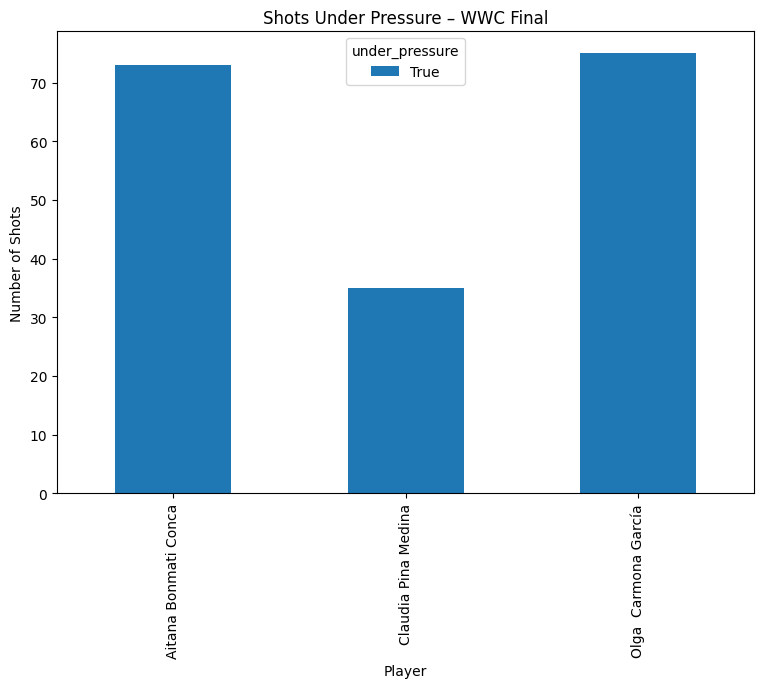

In [25]:
pressure = xG_df.groupby(['player', 'under_pressure']).size().unstack(fill_value=0)

pressure.plot(kind='bar', 
              figsize=(9,6))

plt.title('Shots Under Pressure – WWC Final')
plt.xlabel('Player')
plt.ylabel('Number of Shots')
plt.show()
